In [1]:
import numpyro
import numpy as np
import pandas as pd
import jax.numpy as jnp

import rt_from_frequency_dynamics as rf

/opt/homebrew/lib/python3.9/site-packages/jax/_src/lib/__init__.py:34: UserWarning: JAX on Mac ARM machines is experimental and minimally tested. Please see https://github.com/google/jax/issues/5501 in the event of problems.
  warnings.warn("JAX on Mac ARM machines is experimental and minimally tested. "


In [2]:
data_name = "omicron-ba275"
raw_cases = pd.read_csv(f"../data/{data_name}/{data_name}_location-case-counts.tsv", sep="\t")
raw_seq = pd.read_csv(f"../data/{data_name}/{data_name}_location-variant-sequence-counts.tsv", sep="\t")

In [3]:
# Locations to run
locations = pd.unique(raw_seq["location"])

In [4]:
# Defining Lineage Models
seed_L = 14
forecast_L = 7

# Get delays
v_names = ['Delta', 
           'Omicron 21L', 
           'Omicron 21K', 
           'Omicron 22A', 
           'Omicron 22B', 
           'Omicron 22C',
           'Omicron 22D',
           'other']

gen = rf.pad_delays(
    [rf.discretise_gamma(mn=4.4, std=1.2), # Delta
     rf.discretise_gamma(mn=3.1, std=1.2), # Omicron 21L
     rf.discretise_gamma(mn=3.1, std=1.2), # Omicron 21K
     rf.discretise_gamma(mn=3.1, std=1.2), # Omicron 22A
     rf.discretise_gamma(mn=3.1, std=1.2), # Omicron 22B
     rf.discretise_gamma(mn=3.1, std=1.2), # Omicron 22C
     rf.discretise_gamma(mn=3.1, std=1.2), # Omicron 22D
     rf.discretise_gamma(mn=4.4, std=1.2)] # Other
    )

#gen = rf.discretise_gamma(mn=3.1, std=1.2)

delays = rf.pad_delays([rf.discretise_lognorm(mn=3.1, std=1.0)])


LM_GARW = rf.RenewalModel(gen, delays, seed_L, forecast_L, k=10,
                       RLik = rf.GARW(1e-2, 1e-3, prior_family="Normal"),
                       CLik = rf.ZINegBinomCases(0.05),
                       SLik = rf.DirMultinomialSeq(100),
                       v_names = v_names)

In [5]:
# Params for fitting
opt = numpyro.optim.Adam(step_size=1e-3)
iters = 100_000
num_samples = 3000
save = True
load = False

In [6]:
# Paths for export
path_base = f"../estimates/{data_name}"
path_GARW = path_base + "/GARW"

rf.make_model_directories(path_GARW)

# Running models and exporting results

In [7]:
# Running GARW model
MP_GARW = rf.fit_SVI_locations(raw_cases, raw_seq, locations, 
                             LM_GARW, opt, 
                             iters=iters, num_samples=num_samples, save=save, load=load, path=path_GARW)

Location India finished (1/1).


## Loading results

In [8]:
# Loading past results
def load_models(rc, rs, locations, RM, path=".", num_samples=1000):
    MP = rf.MultiPosterior()
    for i, loc in enumerate(locations):
        LD = rf.get_location_VariantData(rc, rs, loc)
        PH = rf.sample_loaded_posterior(LD, RM, num_samples=num_samples, path=path, name=loc)   
        MP.add_posterior(PH)
        print(f"Location {loc} finished {i+1} / {len(locations)}")
    return MP

In [9]:
MP_GARW = load_models(raw_cases, raw_seq, locations, LM_GARW, path=path_GARW, num_samples=3000)

Location India finished 1 / 1


In [10]:
# Exporting growth info
ps = [0.95, 0.8, 0.5] # Which credible intevals to save

In [11]:
# Export GARW
R_GARW = rf.gather_R(MP_GARW, ps)
r_GARW = rf.gather_little_r(MP_GARW, ps)
I_GARW = rf.gather_I(MP_GARW, ps)
freq_GARW = rf.gather_freq(MP_GARW, ps)

R_GARW.to_csv(f"{path_base}/{data_name}_Rt-combined-GARW.tsv", encoding='utf-8', sep='\t', index=False)
r_GARW.to_csv(f"{path_base}/{data_name}_little-r-combined-GARW.tsv", encoding='utf-8', sep='\t', index=False)
I_GARW.to_csv(f"{path_base}/{data_name}_I-combined-GARW.tsv", encoding='utf-8', sep='\t', index=False)
freq_GARW.to_csv(f"{path_base}/{data_name}_freq-combined-GARW.tsv", encoding='utf-8', sep='\t', index=False)

In [12]:
# Export Forecasts
R_GARW_f = rf.gather_R(MP_GARW, ps, forecast=True)
r_GARW_f = rf.gather_little_r(MP_GARW, ps, forecast=True)
I_GARW_f = rf.gather_I(MP_GARW, ps, forecast=True)
freq_GARW_f = rf.gather_freq(MP_GARW, ps, forecast=True)

R_GARW_f.to_csv(f"{path_base}/{data_name}_Rt-combined-forecast-GARW.tsv", encoding='utf-8', sep='\t', index=False)
r_GARW_f.to_csv(f"{path_base}/{data_name}_little-r-combined-forecast-GARW.tsv", encoding='utf-8', sep='\t', index=False)
I_GARW_f.to_csv(f"{path_base}/{data_name}_I-combined-forecast-GARW.tsv", encoding='utf-8', sep='\t', index=False)
freq_GARW_f.to_csv(f"{path_base}/{data_name}_freq-combined-forecast-GARW.tsv", encoding='utf-8', sep='\t', index=False)

# Making figures

In [13]:
# Figures for export
path_fig = path_base + "/figures"
rf.make_path_if_absent(path_fig)

In [14]:
from rt_from_frequency_dynamics.plotfunctions import *
ps = DefaultAes.ps
alphas = DefaultAes.alphas
v_colors = ["#56e39f", "#89CFF0", "#C70039",  "#5567aa", "#c5d46f", "#aa34a4", "#ec6840", "#808080"]
#v_colors = ["#56e39f", "#ef8f4c", "#ec6840", "#808080"]

v_names = ['Delta', 
           'Omicron 21L', 
           'Omicron 21K', 
           'Omicron 22A', 
           'Omicron 22B', 
           'Omicron 22C',
           'Omicron 22D',
           'other']
color_map = {v : c for c, v in zip(v_colors, v_names)}

In [15]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.transforms as mtransforms

font = {'family' : 'Helvetica',
        'weight' : 'light',
        'size'   : 32}

matplotlib.rc('font', **font)

In [16]:
# What to output?

In [17]:
# Variant frequencies for each location from free R model
def posterior_frequencies_by_country(MP, ps, alphas, color_map, forecast=False):
    locations = list(MP.locator.keys())
    n_locations = len(locations)
        
    size = 10
    n_per_row = 2
    
    if n_locations % n_per_row == 0:
        n_rows = n_locations // n_per_row
    else:
        n_rows = (n_locations // n_per_row) + 1
    
    fig = plt.figure(figsize=(1.5*n_per_row*size, n_rows*size))
    gs = fig.add_gridspec(nrows=n_rows, ncols= n_per_row)
    
    ax_list = []
    for i, loc in enumerate(locations):
        this_col = i % n_per_row
        this_row = i // n_per_row
        ax = fig.add_subplot(gs[this_row, this_col])
        dataset, LD = rf.unpack_model(MP, loc)
        colors = [color_map[v] for v in LD.seq_names]
        
        rf.plot_posterior_frequency(ax, dataset, ps, alphas, colors, forecast=forecast)
        rf.plot_observed_frequency(ax, LD, colors)
        ax.set_title(loc)
    
        # Adding dates depends on whether we're forecasting
        if forecast:
            T_forecast = forecast_L
            ax.axvline(x=len(LD.dates)-1, color='k', linestyle='--')
            rf.add_dates_sep(ax, rf.expand_dates(LD.dates, T_forecast), sep=14)
        else:
            rf.add_dates_sep(ax, LD.dates, sep=14)
            
        if this_col == 0:
            ax.set_ylabel("Variant frequency")
     
    # Make legend
    patches = [matplotlib.patches.Patch(color=c, label=l) for l, c in color_map.items()]
    legend = fig.legend(patches, list(color_map.keys()), ncol=len(color_map.keys()), loc="lower center")  
    legend.get_frame().set_linewidth(2.)
    legend.get_frame().set_edgecolor("k")
    fig.tight_layout()
    fig.subplots_adjust(bottom = 0.1)
    return fig

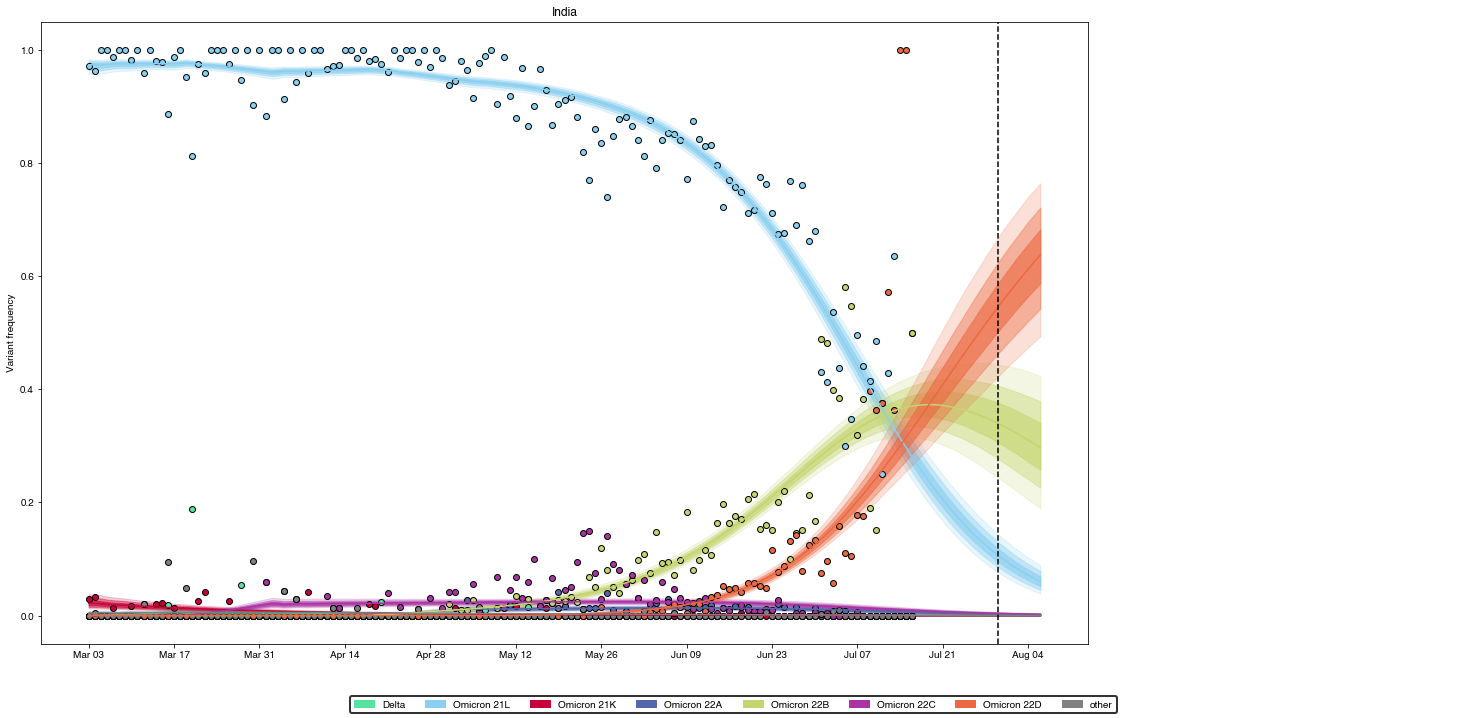

In [18]:
fig_freq = posterior_frequencies_by_country(MP_GARW, ps, alphas, color_map, forecast=True)

In [19]:
# Variant cases for each location from free R model
def posterior_cases_by_country(MP, ps, alphas, color_map, forecast=False):
    locations = list(MP.locator.keys())
    n_locations = len(locations)
        
    size = 10
    n_per_row = 2
    
    if n_locations % n_per_row == 0:
        n_rows = n_locations // n_per_row
    else:
        n_rows = (n_locations // n_per_row) + 1
    
    fig = plt.figure(figsize=(1.9*n_per_row*size, n_rows*size))
    gs = fig.add_gridspec(nrows=n_rows, ncols= n_per_row)
    
    ax_list = []
    for i, loc in enumerate(locations):
        this_col = i % n_per_row
        this_row = i // n_per_row
        ax = fig.add_subplot(gs[this_row, this_col])
        dataset, LD = rf.unpack_model(MP, loc)
        colors = [color_map[v] for v in LD.seq_names]
        
        rf.plot_posterior_I(ax, dataset, ps, alphas, colors, forecast=forecast)
        rf.plot_cases(ax, LD)
        ax.set_title(loc)
        
        
        # Adding dates depends on whether we're forecasting
        if forecast:
            T_forecast = forecast_L
            ax.axvline(x=len(LD.dates)-1, color='k', linestyle='--')
            rf.add_dates_sep(ax, rf.expand_dates(LD.dates, T_forecast), sep=14)
        else:
            rf.add_dates_sep(ax, LD.dates, sep=14)
            
        if this_col == 0:
            ax.set_ylabel("Variant cases")
     
    # Make legend
    patches = [matplotlib.patches.Patch(color=c, label=l) for l, c in color_map.items()]
    legend = fig.legend(patches, list(color_map.keys()), ncol=len(color_map.keys()), loc="lower center")  
    legend.get_frame().set_linewidth(2.)
    legend.get_frame().set_edgecolor("k")
    fig.tight_layout()
    fig.subplots_adjust(bottom = 0.1)
    return fig

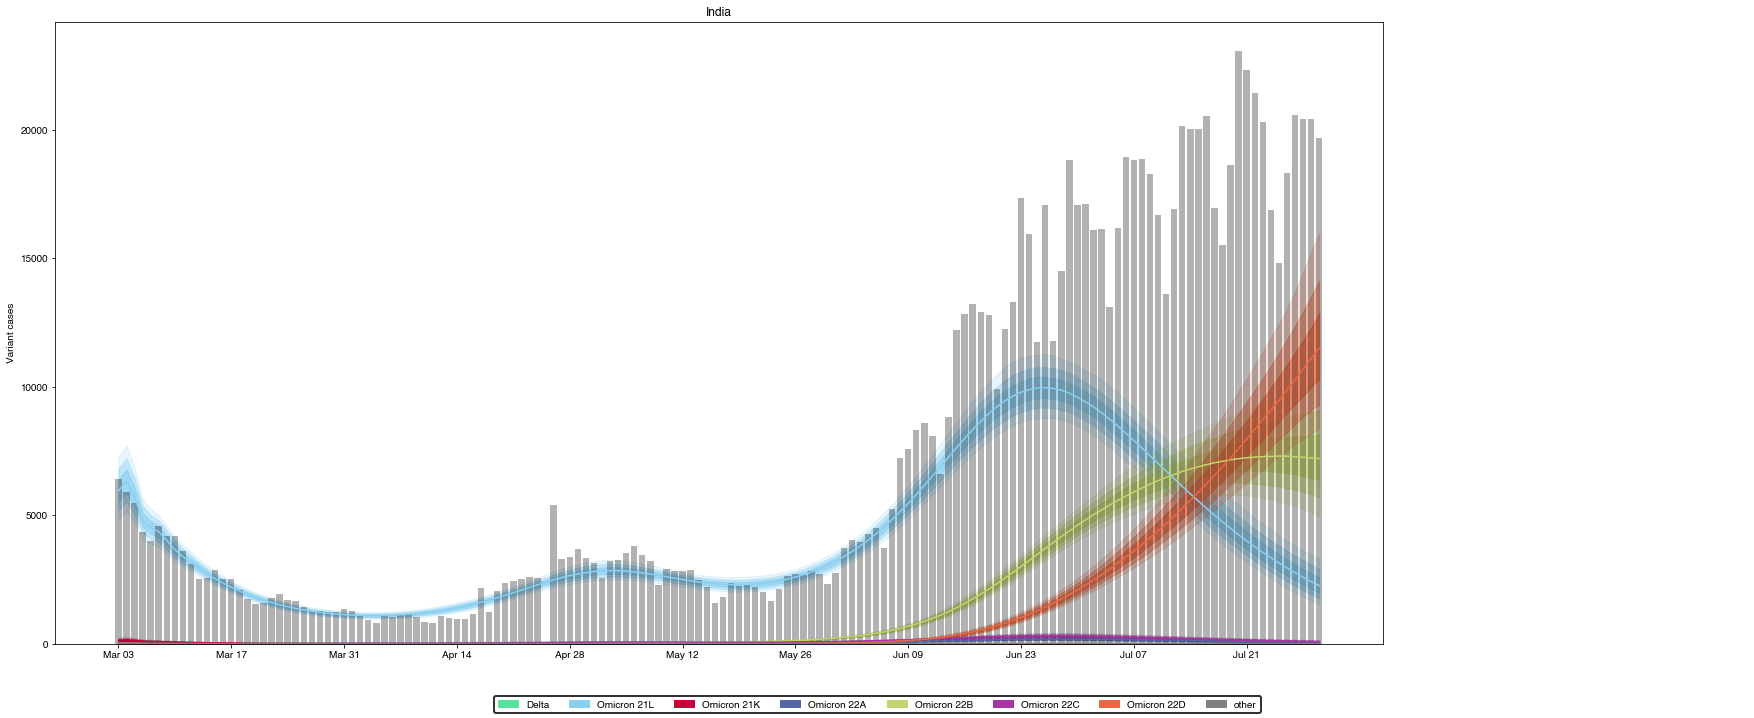

In [20]:
fig_cases = posterior_cases_by_country(MP_GARW, ps, alphas, color_map, forecast=False)

In [21]:
# Variant R for each location from free R model
def posterior_R_by_country(MP, ps, alphas, color_map, forecast=False):
    locations = list(MP.locator.keys())
    n_locations = len(locations)
        
    size = 10
    n_per_row = 2
    
    if n_locations % n_per_row == 0:
        n_rows = n_locations // n_per_row
    else:
        n_rows = (n_locations // n_per_row) + 1
    
    fig = plt.figure(figsize=(1.9*n_per_row*size, n_rows*size))
    gs = fig.add_gridspec(nrows=n_rows, ncols= n_per_row)
    
    ax_list = []
    for i, loc in enumerate(locations):
        this_col = i % n_per_row
        this_row = i // n_per_row
        ax = fig.add_subplot(gs[this_row, this_col])
        dataset, LD = rf.unpack_model(MP, loc)
        colors = [color_map[v] for v in LD.seq_names]
        
        rf.plot_R_censored(ax, dataset, ps, alphas, colors, thres=0.001, forecast=forecast)
        ax.set_title(loc)
        
        
        # Adding dates depends on whether we're forecasting
        if forecast:
            T_forecast = forecast_L
            ax.axvline(x=len(LD.dates)-1, color='k', linestyle='--')
            rf.add_dates_sep(ax, expand_dates(LD.dates, T_forecast), sep=14)
        else:
            rf.add_dates_sep(ax, LD.dates, sep=14)
            
        if this_col == 0:
            ax.set_ylabel("Variant R")
     
    # Make legend
    patches = [matplotlib.patches.Patch(color=c, label=l) for l, c in color_map.items()]
    legend = fig.legend(patches, list(color_map.keys()), ncol=len(color_map.keys()), loc="lower center")  
    legend.get_frame().set_linewidth(2.)
    legend.get_frame().set_edgecolor("k")
    fig.tight_layout()
    fig.subplots_adjust(bottom = 0.1)
    return fig

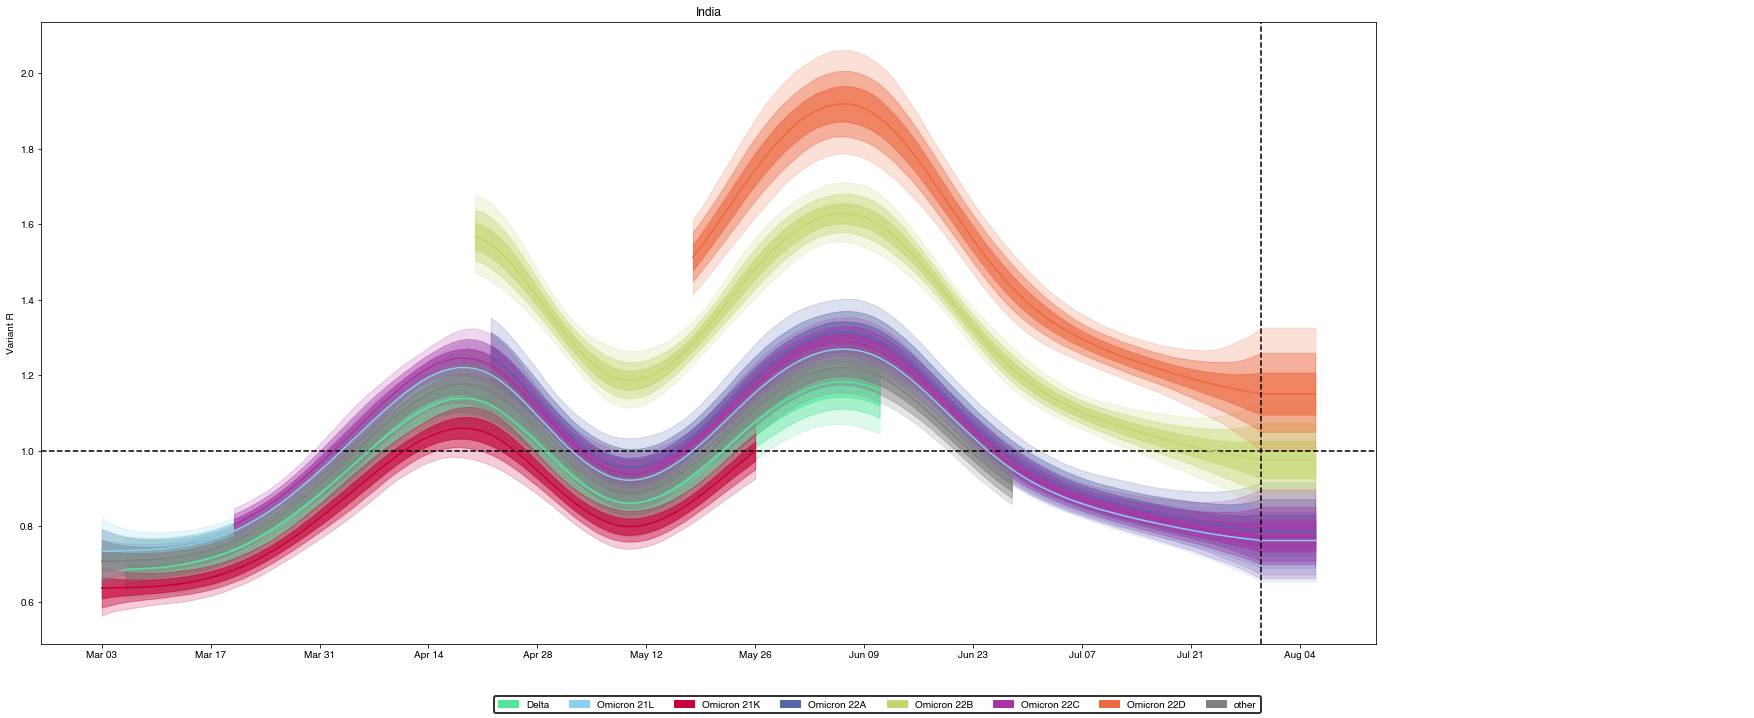

In [22]:
fig_R = posterior_R_by_country(MP_GARW, ps, alphas, color_map, forecast=True)

In [23]:
# Variant frequencies for each location from free R model
def posterior_epidemic_gr_by_country(MP, g, ps, alphas, color_map, forecast=False):
    locations = list(MP.locator.keys())
    n_locations = len(locations)
        
    size = 10
    n_per_row = 2
    
    if n_locations % n_per_row == 0:
        n_rows = n_locations // n_per_row
    else:
        n_rows = (n_locations // n_per_row) + 1
    
    fig = plt.figure(figsize=(1.9*n_per_row*size, n_rows*size))
    gs = fig.add_gridspec(nrows=n_rows, ncols= n_per_row)
    
    ax_list = []
    for i, loc in enumerate(locations):
        this_col = i % n_per_row
        this_row = i // n_per_row
        ax = fig.add_subplot(gs[this_row, this_col])
        dataset, LD = rf.unpack_model(MP, loc)
        colors = [color_map[v] for v in LD.seq_names]
        
        rf.plot_little_r_censored(ax, dataset, ps, alphas, colors, thres=0.01, forecast=forecast)
        ax.set_title(loc)
        
        # Adding dates depends on whether we're forecasting
        if forecast:
            T_forecast = forecast_L
            ax.axvline(x=len(LD.dates)-1, color='k', linestyle='--')
            rf.add_dates_sep(ax, rf.expand_dates(LD.dates, T_forecast), sep=14)
        else:
            rf.add_dates_sep(ax, LD.dates, sep=14)
            
        if this_col == 0:
            ax.set_ylabel("Epidemic Growth Rate")
     
    # Make legend
    patches = [matplotlib.patches.Patch(color=c, label=l) for l, c in color_map.items()]
    legend = fig.legend(patches, list(color_map.keys()), ncol=len(color_map.keys()), loc="lower center")  
    legend.get_frame().set_linewidth(2.)
    legend.get_frame().set_edgecolor("k")
    fig.tight_layout()
    fig.subplots_adjust(bottom = 0.1)
    return fig

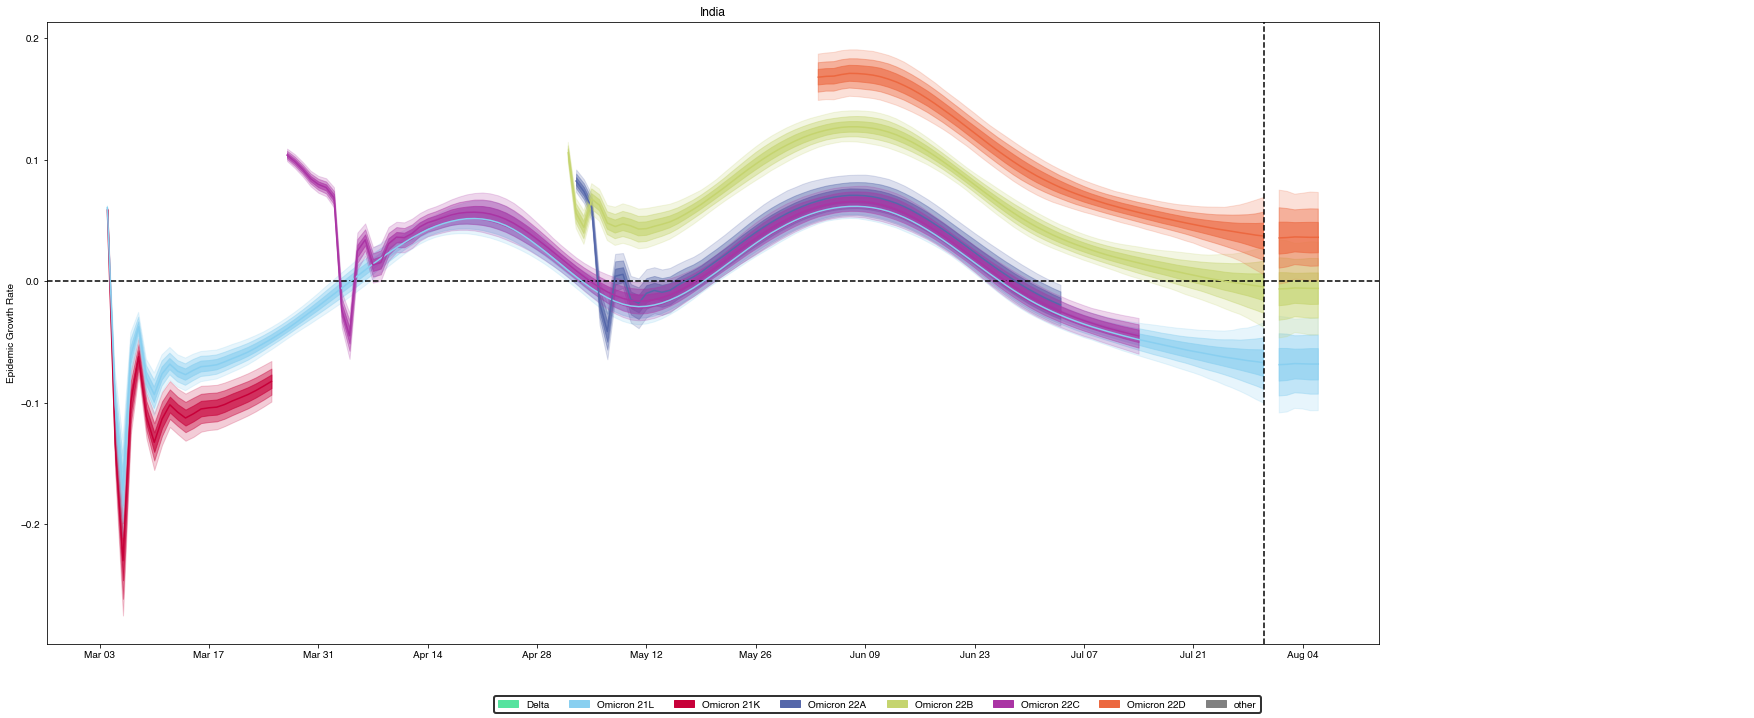

In [24]:
fig_little_r = posterior_epidemic_gr_by_country(MP_GARW, gen, ps, alphas, color_map, forecast=True)

# Saving figures


In [25]:
model_names = ["GARW"]
model_posterior = [MP_GARW]

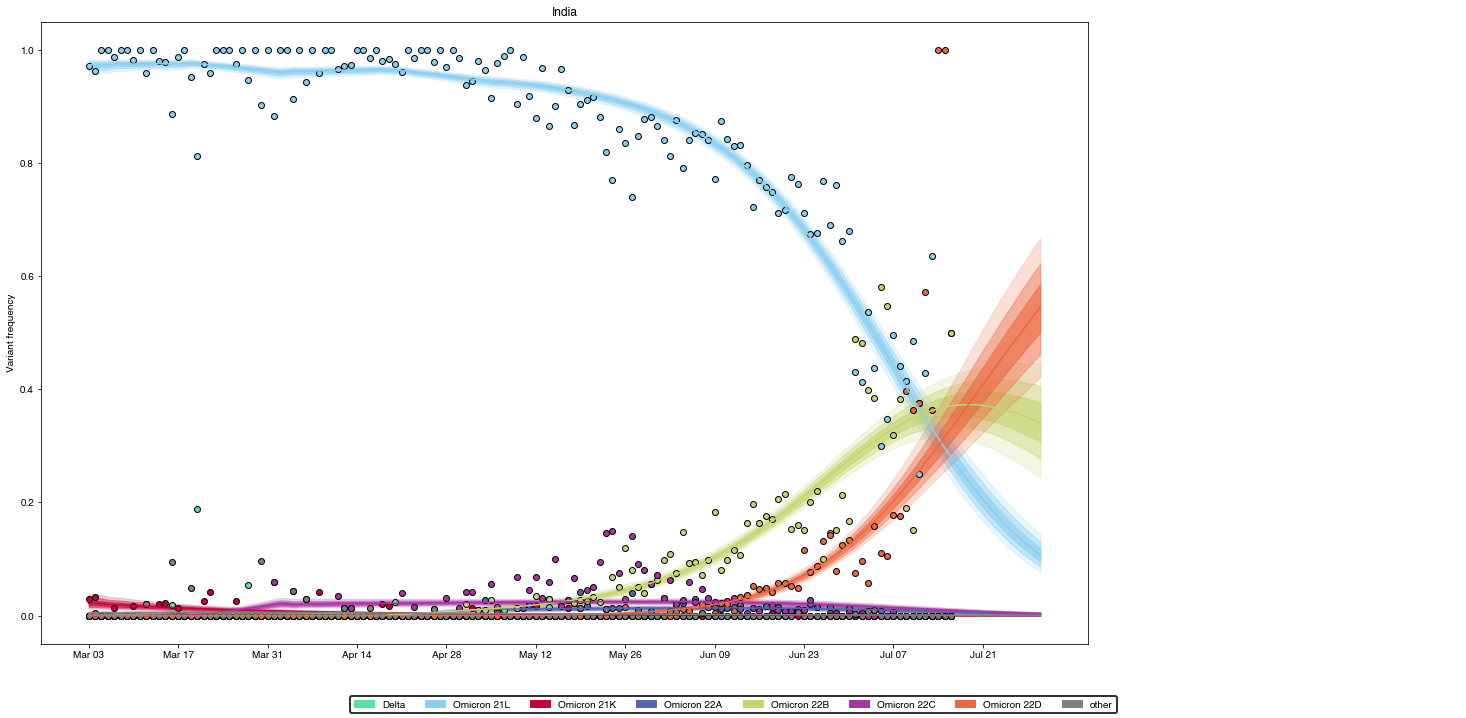

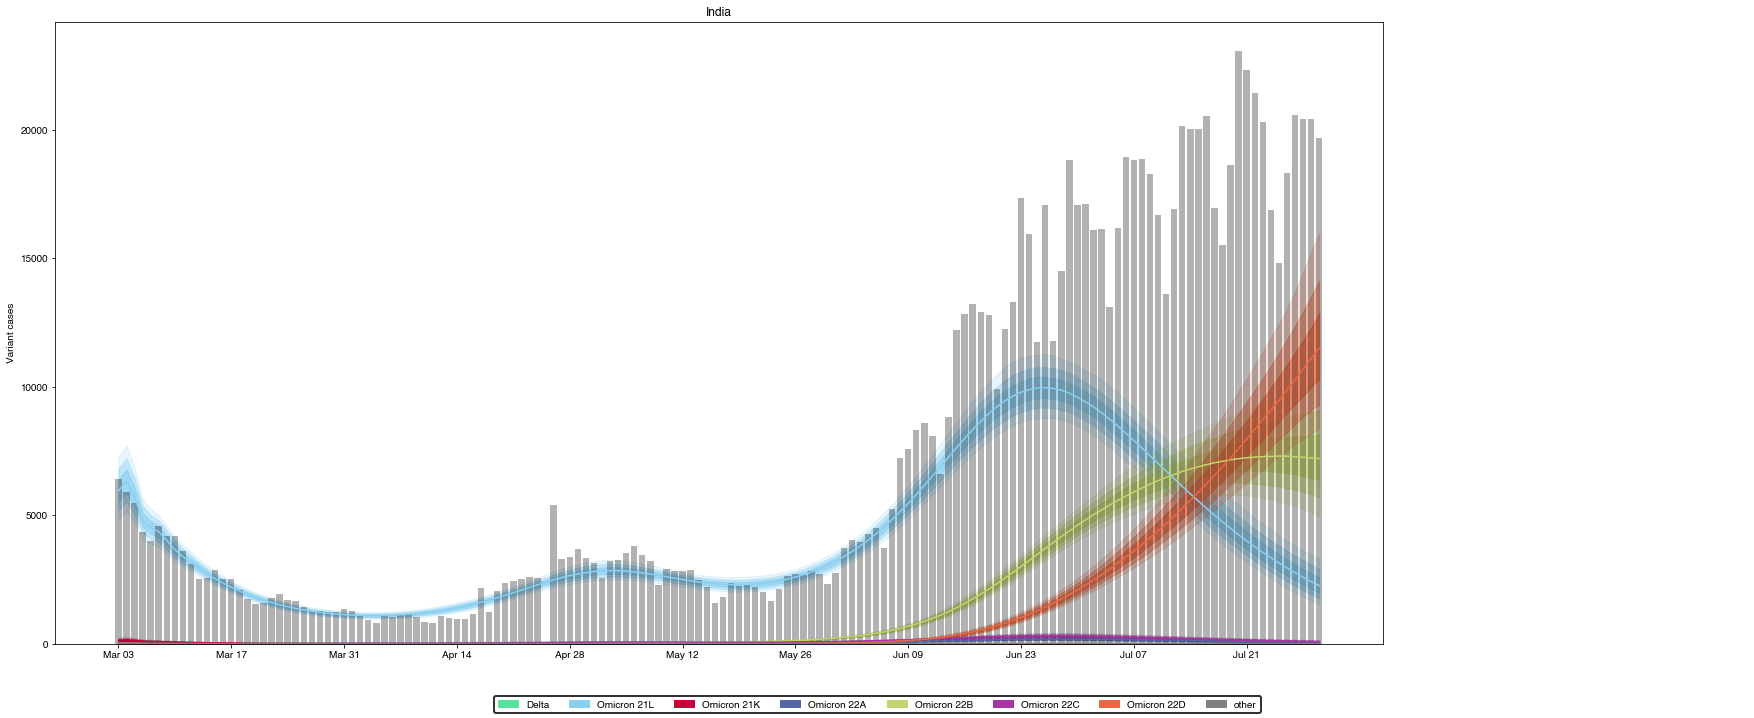

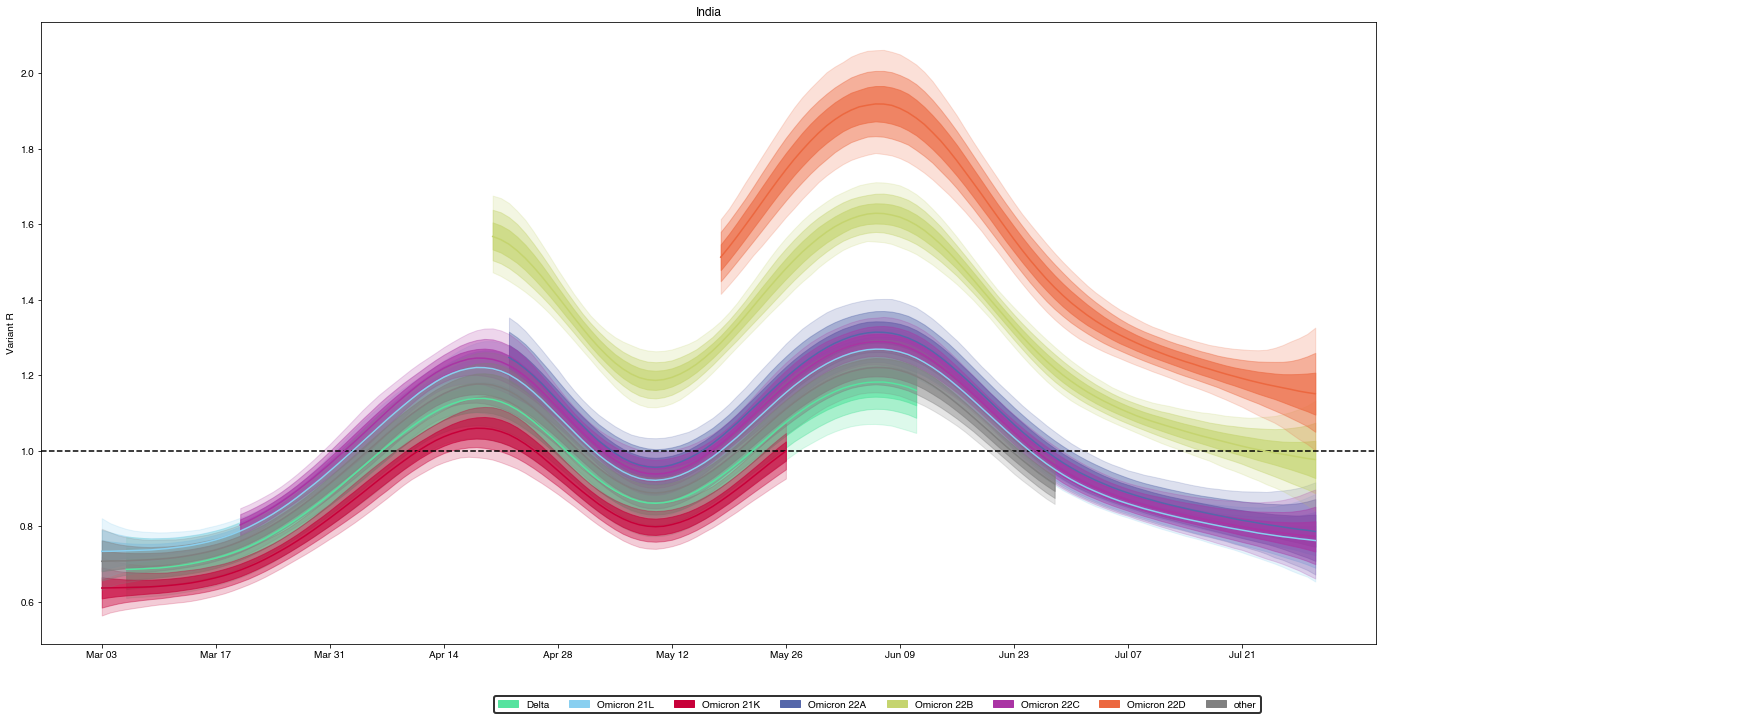

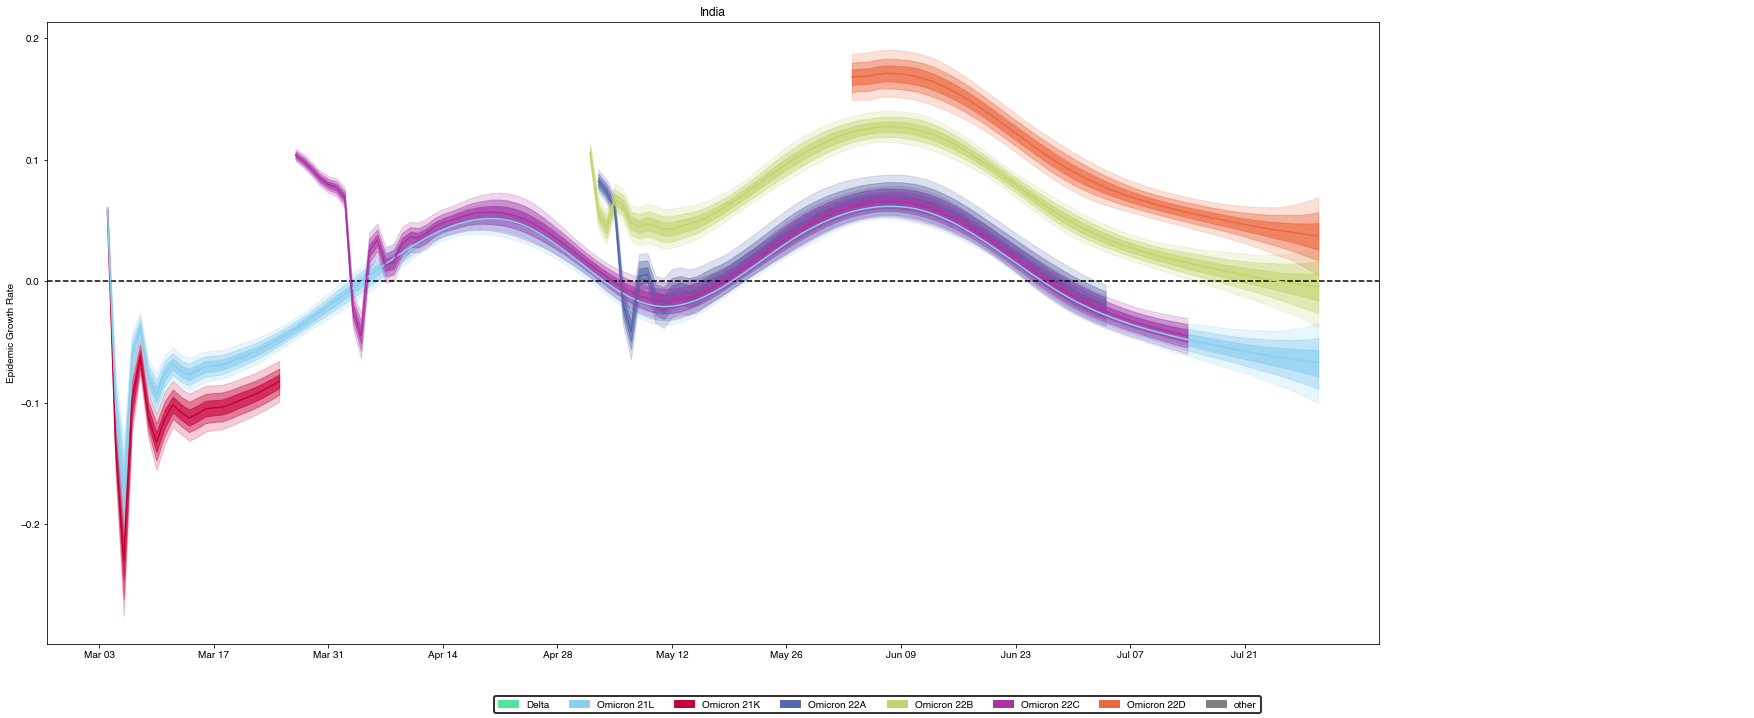

In [26]:
for mname, MP in zip(model_names, model_posterior):
    fig_freq = posterior_frequencies_by_country(MP, ps, alphas, color_map, forecast=False);
    fig_cases = posterior_cases_by_country(MP, ps, alphas, color_map, forecast=False);
    fig_R = posterior_R_by_country(MP, ps, alphas, color_map, forecast=False);
    fig_little_r = posterior_epidemic_gr_by_country(MP, gen, ps, alphas, color_map, forecast=False);
    
    # Export figures
    fig_freq.savefig(f"{path_fig}/{data_name}_frequency-estimates-{mname}.png", facecolor="w", bbox_inches='tight')
    fig_cases.savefig(f"{path_fig}/{data_name}_cases-estimates-{mname}.png", facecolor="w", bbox_inches='tight')
    fig_R.savefig(f"{path_fig}/{data_name}_R-estimates-{mname}.png", facecolor="w", bbox_inches='tight')
    fig_little_r.savefig(f"{path_fig}/{data_name}_little-r-estimates-{mname}.png", facecolor="w", bbox_inches='tight')